In [3]:
import numpy as np 
import pandas as pd 
import yfinance as yf 
import matplotlib.pyplot as plt

from qp import sharpe, var_historical, es_historical


In [4]:
tickers = ["SPY", "EFA", "EEM", "AGG", "GLD"]
start = "2020-01-01"

px = yf.download(tickers, start=start, auto_adjust=True, progress=False)["Close"]
ret = px.pct_change(fill_method=None).dropna()
ret.tail()

Ticker,AGG,EEM,EFA,GLD,SPY
Date,,,,,
2025-09-22,-0.001197,0.004905,0.003226,0.017306,0.004731
2025-09-23,0.001597,0.000563,-0.001929,0.004086,-0.005444
2025-09-24,-0.001894,-0.003377,-0.005799,-0.009063,-0.003182
2025-09-25,-0.001398,-0.005836,-0.007129,0.004165,-0.004614
2025-09-26,0.000700,-0.001894,0.007724,0.005772,0.005729


In [5]:
rf_annual = 0.04 
rf_daily = rf_annual / 252

sharpe_vals = ret.apply(lambda r: sharpe(r.values, risk_free=rf_daily))
sharpe_vals.sort_values(ascending=False)

Ticker
GLD    0.796231
SPY    0.576852
EFA    0.286114
EEM    0.134919
AGG   -0.469479
dtype: float64

In [6]:
irx = yf.download("^IRX", start=start, progress=False)["Close"] / 100.0
rf_daily_series = irx.reindex(ret.index).ffill() / 252  
rf_vec = getattr(rf_daily_series, "squeeze", lambda: rf_daily_series)()
rf_vec = rf_vec.to_numpy().reshape(-1) 


print("ret:", ret.shape, "rf_vec:", rf_vec.shape)


sharpe_irx = ret.apply(lambda col: sharpe(col.to_numpy(), risk_free=rf_vec, ddof=1))
sharpe_irx.sort_values(ascending=False)

ret: (1441, 5) rf_vec: (1441,)


/var/folders/hx/wjmq524d3rj5kn8qc61dk4dh0000gn/T/ipykernel_83769/2664971024.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  irx = yf.download("^IRX", start=start, progress=False)["Close"] / 100.0


Ticker
GLD    0.879268
SPY    0.639300
EFA    0.352893
EEM    0.194843
AGG   -0.271185
dtype: float64

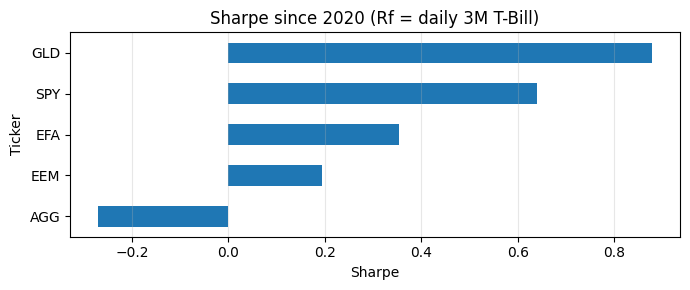

In [7]:
ax = sharpe_irx.sort_values().plot(kind="barh", figsize=(7,3),
                                   title="Sharpe since 2020 (Rf = daily 3M T-Bill)")
ax.set_xlabel("Sharpe"); ax.grid(True, axis="x", alpha=0.3)
plt.tight_layout(); plt.show()

In [8]:
from qp import sharpe
print(sharpe([0.01, 0.02, -0.01], 0.0))

6.928203230275507


VaR 95%  (1-day): 1.6441%
VaR 99%  (1-day): 2.3438%
VaR 99.9%(1-day): 3.0430%


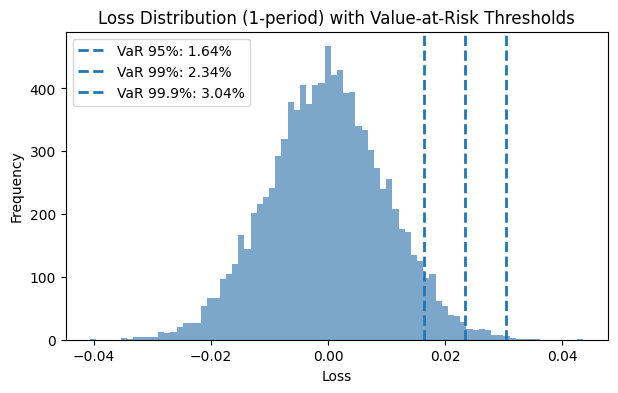

CVar 95%  (1-day): 2.0623%
CVaR 99%  (1-day): 2.6950%
CVaR 99.9%(1-day): 3.3603%


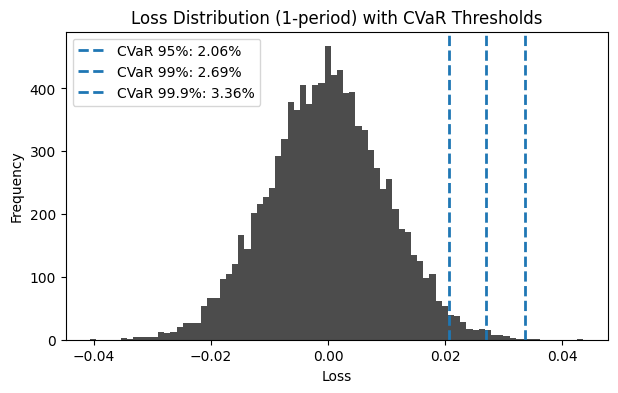

In [9]:
# Simulated daily returns (slightly positive mean, realistic volatility)
rng = np.random.default_rng(42)
returns = rng.normal(0.0003, 0.01, 10_000)

v95 = var_historical(returns, level=0.95)
v99 = var_historical(returns, level=0.99)
v999 = var_historical(returns, level=0.999)

es95 = es_historical(returns, level=0.95)
es99 = es_historical(returns, level=0.99)
es999 = es_historical(returns, level=0.999)

print(f"VaR 95%  (1-day): {v95:.4%}")
print(f"VaR 99%  (1-day): {v99:.4%}")
print(f"VaR 99.9%(1-day): {v999:.4%}")

# Histogram of losses with VaR thresholds
losses = -returns
plt.figure(figsize=(7,4))
plt.hist(losses, bins=80, alpha=0.7, color="steelblue")
for v, lbl in [(v95, "VaR 95%"), (v99, "VaR 99%"), (v999, "VaR 99.9%")]:
    plt.axvline(v, linestyle="--", linewidth=2, label=f"{lbl}: {v:.2%}")
plt.title("Loss Distribution (1-period) with Value-at-Risk Thresholds")
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.legend()
plt.show()


print(f"CVar 95%  (1-day): {es95:.4%}")
print(f"CVaR 99%  (1-day): {es99:.4%}")
print(f"CVaR 99.9%(1-day): {es999:.4%}")

# Histogram of losses with CVaR thresholds
losses = -returns
plt.figure(figsize=(7,4))
plt.hist(losses, bins=80, alpha=0.7, color="black")
for es, lbl in [(es95, "CVaR 95%"), (es99, "CVaR 99%"), (es999, "CVaR 99.9%")]:
    plt.axvline(es, linestyle="--", linewidth=2, label=f"{lbl}: {es:.2%}")
plt.title("Loss Distribution (1-period) with CVaR Thresholds")
plt.xlabel("Loss")
plt.ylabel("Frequency")
plt.legend()
plt.show()

- **VaR (99% = 2.34%)** means that with 99% probability, the one-day loss will not exceed 2.34%.  
  However, VaR does not provide any information about the size of losses once this threshold is breached.

- **CVaR (99% = 2.69%)** takes this further: it measures the *average loss in the worst 1% of scenarios*.  
  In this case, if we end up in the tail beyond the 99% cutoff, the expected loss is 2.69%.

In general, **CVaR ≥ VaR**, since CVaR captures the *severity of extreme losses*, while VaR only marks the boundary.